In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "C:\\Users\\Saber\\Desktop\\research\\Dropbox\\SwIRL_GPU\\Stock Market Research\\Data_Source\\master_stock.csv"

In [80]:
df_base = pd.read_csv(DATA_PATH)
df_base.head()

C:\Users\Saber\AppData\Local\Temp\ipykernel_36152\1385438652.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_base = pd.read_csv(DATA_PATH)


,Tic,Date,Price
0,A,2011-01-03,30.317816
1,A,2011-01-04,30.035487
2,A,2011-01-05,29.970334
3,A,2011-01-06,30.028247
4,A,2011-01-07,30.129596


In [52]:
value_counts_invalid.index

Index(['1,008.30', '9,424.80', '7,530.80', '9,529.60', '41,929.00', '1,264.30',
       '3,870.30', '21,517.20', '21,365.20', '7,208.00',
       ...
       '33,991.50', '43,425.90', '16,829.80', '44,156.90', '1,012.70',
       '17,172.30', '4,004.10', '7,759.10', '36,793.20', '7,321.50'],
      dtype='object', name='Price', length=2605)

In [81]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13011203 entries, 0 to 13011202
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Tic     object
 1   Date    object
 2   Price   object
dtypes: object(3)
memory usage: 297.8+ MB


In [82]:
df_base.isna().sum()/len(df_base)

Tic      0.000419
Date     0.000000
Price    0.009706
dtype: float64

# Initial Transformations 

NOTE: ensure consistent date and price formatting
- date should be datetime `%y-%m-%d `
- price should be `float`

In [83]:
df_base[df_base['Tic'] == 'TSM']

,Tic,Date,Price
11666216,TSM,2011-01-03,12.59
11666217,TSM,2011-01-04,12.63
11666218,TSM,2011-01-05,12.36
11666219,TSM,2011-01-06,12.87
11666220,TSM,2011-01-07,13.07
...,...,...,...
11669918,TSM,2025-09-22,272.63
11669919,TSM,2025-09-23,282.71
11669920,TSM,2025-09-24,280.71
11669921,TSM,2025-09-25,276.66


In [84]:
df_tsm = df_base[df_base['Tic'] == 'TSM'].copy()
df_tsm['Date'] = pd.to_datetime(df_tsm['Date'], format='mixed')
df_filtered = df_tsm[df_tsm['Date'].dt.month == 5].copy()
df_filtered['Tic'] = df_tsm['Tic'].astype(str)
# df_filtered['Price'] = df_tsm['Price'].astype(str)
# Remove single quotes AND commas, then cast to float
df_filtered['prices_clean'] = df_filtered['Price'].astype(str).str.replace(r"[',]", "", regex=True).astype(float)
# df_returns['Price_Lag1'] = df_returns.groupby('Tic')['Price'].shift(1)
# df_returns['Returns'] = (df_returns['Price'] - df_returns['Price_Lag1']) / df_returns['Price_Lag1']
df_filtered.drop('Price', axis=1, inplace=True)
df_filtered.head()

,Tic,Date,prices_clean
11666298,TSM,2011-05-02,13.51
11666299,TSM,2011-05-03,13.46
11666300,TSM,2011-05-04,13.44
11666301,TSM,2011-05-05,13.55
11666302,TSM,2011-05-06,13.75


In [85]:
df_filtered['prices_clean'].isna().sum()

np.int64(0)

In [86]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319 entries, 11666298 to 11669840
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Tic           319 non-null    object        
 1   Date          319 non-null    datetime64[ns]
 2   prices_clean  319 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.0+ KB


## Add Returns

In [88]:
df_filtered['Price_Lag1'] = df_filtered.groupby('Tic')['prices_clean'].shift(1)
df_filtered['Returns'] = (df_filtered['prices_clean'] - df_filtered['Price_Lag1']) / df_filtered['Price_Lag1']
df_filtered[['prices_clean', 'Price_Lag1', 'Returns']].head()
df_filtered.dropna(subset=['Returns'], inplace=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 11666300 to 11669840
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Tic           317 non-null    object        
 1   Date          317 non-null    datetime64[ns]
 2   prices_clean  317 non-null    float64       
 3   Price_Lag1    317 non-null    float64       
 4   Returns       317 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 14.9+ KB


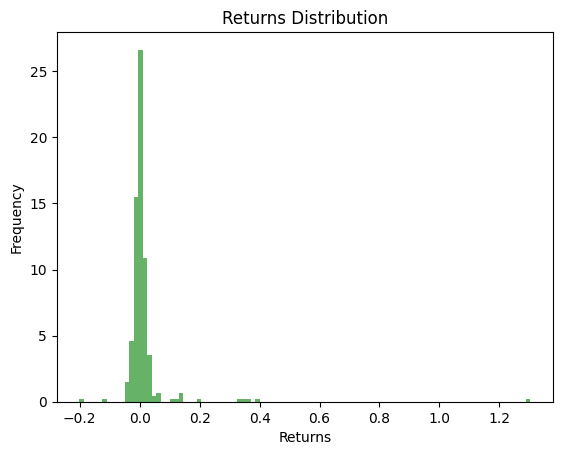

In [100]:
X = df_filtered['Returns']
# b = int(2*(len(X)**(1/3)))
b = 100
ax = X.plot(kind='hist', bins=b, density=True, alpha=0.6, color='g')
# ax.set_xlim(-5, 5)  # Set x-axis limits
plt.title("Returns Distribution")
plt.xlabel("Returns")    
plt.show()

# Non-parametric Fit

- chi sqr GOF with normal assumption
- approximate beta params and chi sqr GOF with KDE 

## Fitting KDE

In [52]:
%pip install KDEpy

Note: you may need to restart the kernel to use updated packages.


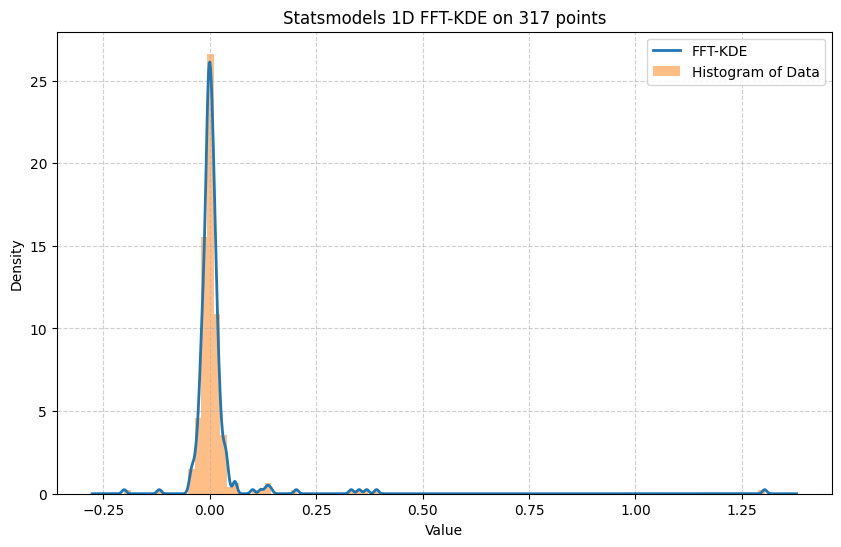

0.005


In [104]:
import numpy as np
import matplotlib.pyplot as plt
from KDEpy import FFTKDE

# 2. Instantiate the KDEUnivariate class
# This class is specifically for 1D data.
kde = FFTKDE(kernel='gaussian', bw=0.005).fit(X.to_numpy().reshape(-1, 1)) 

# 3. Fit the model
# bw='silverman': Uses Silverman's rule-of-thumb for bandwidth selection.
# fft=True: Explicitly tells it to use the FFT-based method.
#         (This is often the default, but it's good to be explicit).
# gridsize: Optionally, you can suggest the number of grid points for the FFT.
x, y = kde.evaluate()

# 4. Access the results
# The results are pre-computed and stored in the object.
# kde.support: The x-axis grid points where the density was evaluated.
# kde.density: The y-axis density (KDE) values at each support point.

# 5. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, lw=2, label='FFT-KDE')

# (Optional) Plot a histogram to compare
plt.hist(X, bins=b, density=True, alpha=0.5, label='Histogram of Data')
plt.title(f'Statsmodels 1D FFT-KDE on {len(X):,} points')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print(f'{kde.bw}')

# Parametric Fit: Non-Central T

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 2. Fit the Non-Central t-distribution
# 'nct' models both degrees of freedom (tails) and non-centrality (skew)
# It returns (df, nc, loc, scale) 
params = stats.nct.fit(X)
df_est, nc_est, loc_est, scale_est = params

print(f"Fitted Params -> DF: {df_est:.2f}, Skew(nc): {nc_est:.2f}, Loc: {loc_est:.2f}, Scale: {scale_est:.2f}")

Fitted Params -> DF: 1.59, Skew(nc): 0.34, Loc: -0.00, Scale: 0.01


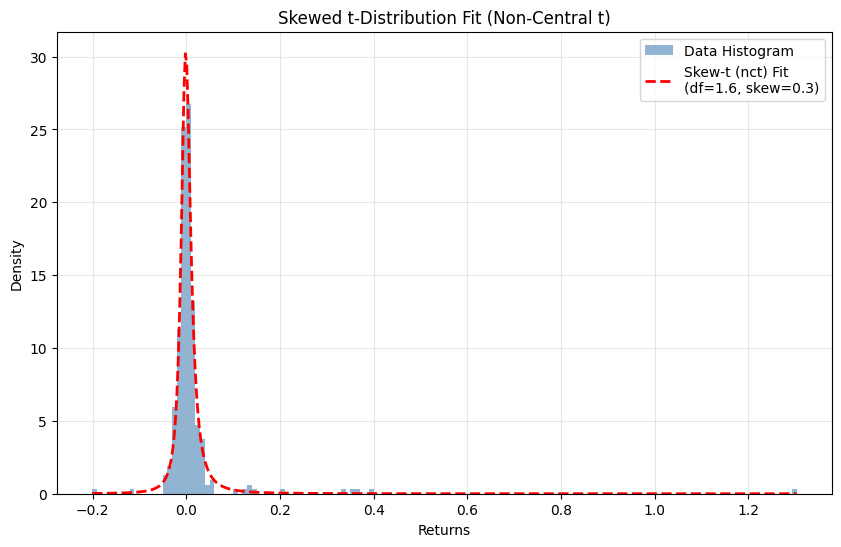

In [106]:
x = np.linspace(X.min(), X.max(), 500)

plt.figure(figsize=(10, 6))

# Plot the histogram of the data
plt.hist(X, bins=150, density=True, alpha=0.6, color='steelblue', label='Data Histogram')

# Plot the PDF of the fitted distribution
pdf_values = stats.nct.pdf(x, df_est, nc_est, loc_est, scale_est)
plt.plot(x, pdf_values, 'r--', lw=2,
         label=f'Skew-t (nct) Fit\n(df={df_est:.1f}, skew={nc_est:.1f})')

plt.title('Skewed t-Distribution Fit (Non-Central t)')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KS Test

In [110]:
import scipy.stats as stats
import numpy as np

# 1. Get all continuous distribution objects
all_dists = [getattr(stats, d) for d in dir(stats) 
             if isinstance(getattr(stats, d), stats.rv_continuous)]

# 2. Filter for distributions where support is (-inf, +inf)
infinite_support_dists = []

for dist in all_dists:
    # We check the default support bounds .a and .b
    if dist.a == -np.inf and dist.b == np.inf:
        infinite_support_dists.append(dist.name)

print(f"Found {len(infinite_support_dists)} distributions with support (-inf, inf):")
print(infinite_support_dists)

Found 37 distributions with support (-inf, inf):
['cauchy', 'crystalball', 'dgamma', 'dweibull', 'exponnorm', 'genextreme', 'genhyperbolic', 'genlogistic', 'gennorm', 'gumbel_l', 'gumbel_r', 'hypsecant', 'irwinhall', 'jf_skew_t', 'johnsonsu', 'kappa4', 'landau', 'laplace', 'laplace_asymmetric', 'levy_stable', 'loggamma', 'logistic', 'loguniform', 'moyal', 'nct', 'norm', 'norminvgauss', 'pearson3', 'powernorm', 'reciprocal', 'skewcauchy', 'skewnorm', 't', 'truncnorm', 'truncweibull_min', 'tukeylambda', 'vonmises']


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# KS test: returns series vs Non-central t (skew-t)
# Uses previously fitted params if available; otherwise fits now.

# 1) Pull sample
if 'Returns' not in df_filtered.columns:
    raise ValueError("Returns column not found in df_filtered. Compute returns first.")

sample = df_filtered['Returns'].dropna().to_numpy()
n = sample.size

# 2) Get/fallback-fit nct parameters
try:
    params  # from earlier fitting cell (params = stats.nct.fit(X))
except NameError:
    params = stats.nct.fit(sample)

df_est, nc_est, loc_est, scale_est = params

# 3) Run KS test against nct with fitted params
ks_stat, ks_p = stats.kstest(sample, 'nct', args=(df_est, nc_est, loc_est, scale_est))

# 4) Summarize results in a DataFrame
alpha = 0.05
ks_nct_df = pd.DataFrame([
    {
        'distribution': 'Non-central t',
        'D_stat': ks_stat,
        'p_value': ks_p,
        'decision_alpha_0.05': 'Fail to reject' if ks_p > alpha else 'Reject',
        'df': df_est,
        'nc': nc_est,
        'loc': loc_est,
        'scale': scale_est,
        'n': n
    }
])

ks_nct_df

,distribution,D_stat,p_value,decision_alpha_0.05,param_1,param_2,param_3,param_4,n
0,Normal,0.337973,8.333837e-33,Reject,0.010966,0.088054,NaN,NaN,317
1,Non-central t,0.026079,9.785370e-01,Fail to reject,1.590897,0.336180,-0.003865,0.01121,317
